In [69]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_symmetric
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, SpectralClustering, spectral_clustering, k_means
from sklearn.manifold import spectral_embedding

from graspologic.plot import adjplot
from graspologic.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed   
from graspologic.utils import remap_labels, is_symmetric
from graspologic.simulations import sbm

from tqdm import tqdm
import warnings

In [70]:
n_sims = 50
n_verts = [100, 500, 1000, 2000, 3000, 4000, 5000]

B_aff = np.array([[0.050, 0.013], [0.013, 0.051]])
B_core = np.array([[0.011, 0.027], [0.027, 0.079]])

warnings.filterwarnings("ignore")

In [80]:
#example of going from block matrix to probability matrix to latent position matrix to k neighbors graph

#given affinity block matrix
B_aff = np.array([[0.050, 0.013], [0.013, 0.051]])

#will iterate through list of n_verts in simulation, but use n_verts=6 as example (3 verts per block)
n = 6

#make probability matrix
P = np.zeros((n, n))
P[0:int(n/2),0:int(n/2)] = B_aff[0, 0]
P[int(n/2):n, int(n/2):n] = B_aff[1, 1]
P[0:int(n/2), int(n/2):n] = B_aff[0, 1]
P[int(n/2):n, 0:int(n/2)] = B_aff[1, 0]

#make latent position matrix
U, S, V = np.linalg.svd(P)

#sample half the points from U
X = U[0:int(n/2), 0:2] @ np.sqrt(np.diag(S[0:2]))

#sample half the points from V^T
Y = V.T[int(n/2):n, 0:2] @ np.sqrt(np.diag(S[0:2]))

#concatenate the two matrices to get the full latent position matrix
lat_mat = np.concatenate((X, Y), axis=0)

#get k_neighbors graph from latent position matrix
kn_graph = kneighbors_graph(lat_mat, n_neighbors=4)
print(kn_graph.toarray())
print(is_symmetric(kn_graph))


[[0. 1. 1. 1. 1. 0.]
 [1. 0. 1. 1. 1. 0.]
 [1. 1. 0. 1. 1. 0.]
 [1. 1. 0. 0. 1. 1.]
 [1. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 1. 0.]]
False


In [73]:
def calc_ari(B, embed_method):
    rows = []
    
    #progress bar for the outer loop over n_verts
    for n in tqdm(n_verts, desc="Vertices"):
        # Generate the true labels
        labels_sbm = int(n/2) * [0] + int(n/2) * [1]

        #make probability matrix from block matrix
        P = np.zeros((n, n))
        P[0:int(n/2),0:int(n/2)] = B_aff[0, 0]
        P[int(n/2):n, int(n/2):n] = B_aff[1, 1]
        P[0:int(n/2), int(n/2):n] = B_aff[0, 1]
        P[int(n/2):n, 0:int(n/2)] = B_aff[1, 0]

        #make latent position matrix
        U, S, V = np.linalg.svd(P)

        #sample half the points from U
        X = U[0:int(n/2), 0:2] @ np.sqrt(np.diag(S[0:2]))

        #sample half the points from V^T
        Y = V.T[int(n/2):n, 0:2] @ np.sqrt(np.diag(S[0:2]))

        #concatenate the two matrices to get the full latent position matrix
        lat_mat = np.concatenate((X, Y), axis=0)

        #get k_neighbors graph from latent position matrix (k=sqrt(n))
        kn_graph = kneighbors_graph(lat_mat, n_neighbors=int(np.sqrt(n)))
        kn_graph = kn_graph.toarray()

        #progress bar for the inner loop over simulations
        for _ in tqdm(range(n_sims), desc="Simulations", position=1, leave=True):
            #choose embedding method
            if embed_method == "ase":
                ase = AdjacencySpectralEmbed(n_components=2)
                Xhat, Yhat = ase.fit_transform(kn_graph)
            elif embed_method == "lse":
                lse = LaplacianSpectralEmbed(n_components=2)
                Xhat, Yhat = lse.fit_transform(kn_graph)
            elif embed_method == "sklearn":
                Xhat = spectral_embedding(kn_graph, n_components=2)


            #concatenate Xhat and Yhat if using ase or lse
            if embed_method == "ase" or embed_method == "lse":
                Xhat = np.concatenate((Xhat, Yhat), axis=1)

            #calculate the ARI score
            labels_kmeans = KMeans(n_clusters=2).fit_predict(Xhat)
            ari = adjusted_rand_score(labels_sbm, labels_kmeans)
            result = {
                "test": embed_method,
                "n_vert": n,
                "ari": ari
            }
            rows.append(result)
        print(n)

    results = pd.DataFrame(rows)
    return results

In [74]:
#comparison of embedding methods on affinity graph (LSE should do best)
ari_aff_lse_df = calc_ari(B = B_aff, embed_method = "lse")
ari_aff_ase_df = calc_ari(B = B_aff, embed_method = "ase")
ari_aff_sklearn_df = calc_ari(B = B_aff, embed_method = "sklearn")
ari_aff_df = pd.concat([ari_aff_lse_df, ari_aff_sklearn_df])
ari_aff_df = pd.concat([ari_aff_lse_df, ari_aff_ase_df, ari_aff_sklearn_df])
ari_aff_df.to_csv("ari_aff_df.csv")

Vertices:  14%|█▍        | 1/7 [00:03<00:22,  3.72s/it]

100


Vertices:  29%|██▊       | 2/7 [00:10<00:26,  5.28s/it]

500


Vertices:  43%|████▎     | 3/7 [00:31<00:51, 12.86s/it]

1000


Vertices:  57%|█████▋    | 4/7 [01:58<02:05, 41.83s/it]

2000


Vertices:  71%|███████▏  | 5/7 [05:19<03:18, 99.46s/it]

3000


Vertices:  86%|████████▌ | 6/7 [12:43<03:36, 216.45s/it]

4000


Vertices: 100%|██████████| 7/7 [24:49<00:00, 212.76s/it]


5000


Vertices:  14%|█▍        | 1/7 [00:01<00:09,  1.62s/it]

100


Vertices:  29%|██▊       | 2/7 [00:07<00:21,  4.37s/it]

500


Vertices:  43%|████▎     | 3/7 [00:27<00:45, 11.36s/it]

1000


Vertices:  57%|█████▋    | 4/7 [00:58<00:56, 18.99s/it]

2000


Vertices:  71%|███████▏  | 5/7 [02:12<01:17, 39.00s/it]

3000


Vertices:  86%|████████▌ | 6/7 [04:42<01:16, 76.50s/it]

4000


Vertices: 100%|██████████| 7/7 [09:47<00:00, 83.93s/it] 


5000


Vertices:  14%|█▍        | 1/7 [00:00<00:04,  1.26it/s]

100


Vertices:  29%|██▊       | 2/7 [00:03<00:08,  1.68s/it]

500


Vertices:  43%|████▎     | 3/7 [00:10<00:17,  4.40s/it]

1000


Vertices:  57%|█████▋    | 4/7 [00:34<00:35, 11.92s/it]

2000


Vertices:  71%|███████▏  | 5/7 [01:49<01:09, 34.88s/it]

3000


Vertices:  86%|████████▌ | 6/7 [04:09<01:10, 70.38s/it]

4000


Vertices: 100%|██████████| 7/7 [09:40<00:00, 82.94s/it] 


5000


In [75]:
#get the means across the sims (groupby test and n_vert)
ari_aff_means = ari_aff_df.groupby(["test", "n_vert"]).mean()
ari_aff_means

ari
test    n_vert          
ase     100     0.498978
        500     0.632767
        1000    0.664953
        2000    0.719090
        3000    0.791741
        4000    0.657694
        5000    0.717914
lse     100     0.617848
        500     0.143733
        1000    0.006560
        2000    0.539318
        3000    0.455777
        4000    0.680373
        5000    0.600228
sklearn 100     0.295346
        500     0.346168
        1000    0.249671
        2000    0.238106
        3000    0.221293
        4000    0.271046
        5000    0.269690

Text(0.5, 1.0, 'ARI of Affinity Graph using Different Embedding Methods')

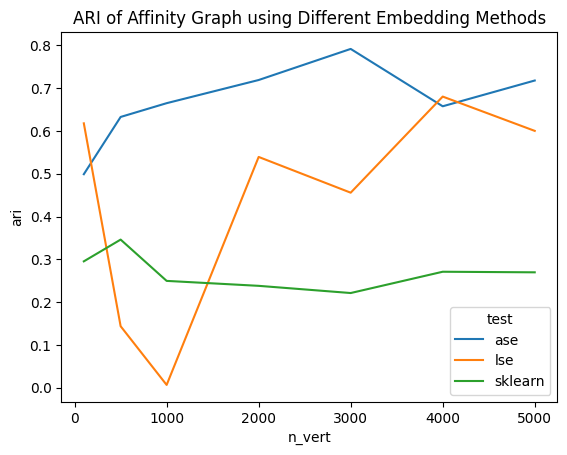

In [76]:
#make lse vs sklearn affinity plot
sns.lineplot(data=ari_aff_means, x="n_vert", y="ari", hue="test", errorbar=None)
plt.title('ARI of Affinity Graph using Different Embedding Methods')

In [77]:
#comparison of embedding methods on core periphery graph (ASE should do best)
ari_core_ase_df = calc_ari(B = B_core, embed_method = "ase")
ari_core_lse_df = calc_ari(B = B_core, embed_method = "lse")
ari_core_sklearn_df = calc_ari(B = B_core, embed_method = "sklearn")
ari_core_df = pd.concat([ari_core_ase_df, ari_core_sklearn_df])
ari_core_df = pd.concat([ari_core_ase_df, ari_core_lse_df, ari_core_sklearn_df])
ari_core_df.to_csv("ari_core_df.csv")

Vertices:  14%|█▍        | 1/7 [00:00<00:05,  1.07it/s]

100


Vertices:  29%|██▊       | 2/7 [00:04<00:12,  2.40s/it]

500


Vertices:  43%|████▎     | 3/7 [00:13<00:21,  5.38s/it]

1000


Vertices:  57%|█████▋    | 4/7 [00:44<00:46, 15.59s/it]

2000


Vertices:  71%|███████▏  | 5/7 [02:01<01:15, 37.69s/it]

3000


Vertices:  86%|████████▌ | 6/7 [04:21<01:12, 72.46s/it]

4000


Vertices: 100%|██████████| 7/7 [09:18<00:00, 79.85s/it] 


5000


Vertices:  14%|█▍        | 1/7 [00:00<00:02,  2.72it/s]

100


Vertices:  29%|██▊       | 2/7 [00:02<00:05,  1.18s/it]

500


Vertices:  43%|████▎     | 3/7 [00:09<00:16,  4.13s/it]

1000


Vertices:  57%|█████▋    | 4/7 [00:48<00:53, 17.88s/it]

2000


Vertices:  71%|███████▏  | 5/7 [03:05<02:01, 60.78s/it]

3000


Vertices:  86%|████████▌ | 6/7 [09:01<02:41, 161.22s/it]

4000


Vertices: 100%|██████████| 7/7 [18:35<00:00, 159.32s/it]


5000


Vertices:  14%|█▍        | 1/7 [00:00<00:02,  2.11it/s]

100


Vertices:  29%|██▊       | 2/7 [00:02<00:05,  1.10s/it]

500


Vertices:  43%|████▎     | 3/7 [00:07<00:12,  3.21s/it]

1000


Vertices:  57%|█████▋    | 4/7 [00:30<00:32, 10.96s/it]

2000


Vertices:  71%|███████▏  | 5/7 [01:34<01:00, 30.04s/it]

3000


Vertices:  86%|████████▌ | 6/7 [03:40<01:02, 62.52s/it]

4000


Vertices: 100%|██████████| 7/7 [09:26<00:00, 80.99s/it] 


5000


In [78]:
#get the means across the sims (groupby test and n_vert)
ari_core_means = ari_core_df.groupby(["test", "n_vert"]).mean()
ari_core_means

ari
test    n_vert          
ase     100     0.633869
        500     0.515253
        1000    0.548266
        2000    0.659324
        3000    0.732456
        4000    0.578092
        5000    0.638231
lse     100     0.656064
        500     0.125018
        1000    0.008308
        2000    0.459511
        3000    0.458525
        4000    0.640533
        5000    0.540224
sklearn 100     0.341407
        500     0.232783
        1000    0.318776
        2000    0.367424
        3000    0.269228
        4000    0.328446
        5000    0.387149

Text(0.5, 1.0, 'ARI of Core Periphery Graph using Different Embedding Methods')

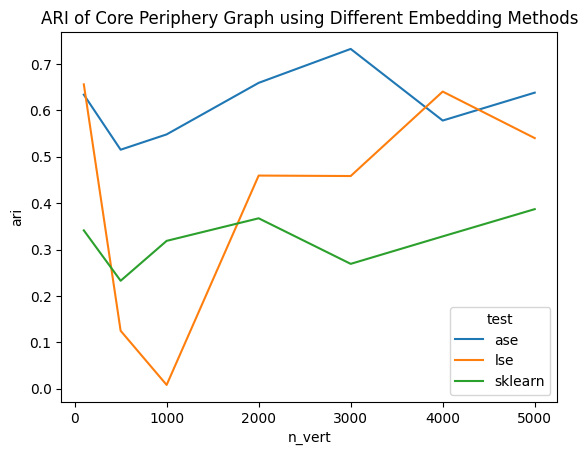

In [79]:
#make ase vs sklearn core periphery plot
sns.lineplot(data=ari_core_means, x="n_vert", y="ari", hue="test", errorbar=None)
plt.title('ARI of Core Periphery Graph using Different Embedding Methods')